In [1]:
import numpy as np
#from scipy import stats
import scarlet
import scarlet.display

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a good colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno', interpolation='none', origin='lower')

from astropy.io import fits
from astropy.wcs import WCS
from matplotlib.colors import LogNorm

from functools import partial
from scarlet.display import AsinhMapping
#from photutils.psf import extract_stars
from astropy.table import Table
from astropy.nddata import NDData
from astropy.visualization import simple_norm
#from photutils import EPSFBuilder
from astropy.visualization.lupton_rgb import AsinhMapping, LinearMapping
import sep
from functools import partial
import image_registration
import pandas as pd
import pandasql as ps

In [2]:
channels = ['u','g','r','i','z']

In [3]:
def makeCatalog(img, lvl = 4):
    if np.size(img.shape) == 3:
        detect = img.mean(axis=0) # simple average for detection
    else:
        detect = img

    bkg = sep.Background(detect)
    catalog = sep.extract(detect, lvl, err=bkg.globalrms)
    if np.size(img.shape) == 3:
        bg_rms = np.array([sep.Background(band).globalrms for band in img])
    else:
        bg_rms =  sep.Background(detect).globalrms
    return catalog, bg_rms

In [4]:
def alignImages(hdulist):
#     shaperoni = im1_aligned_to_im2.shape
#     xsegments = int(shaperoni[0]/100)
#     ylen = shaperoni[0] 
    alignedHDU = [hdulist[0]]
    im2 = hdulist[0]
    for image in range(1,len(hdulist)):
        im1 = hdulist[image]
        yoff,xoff = image_registration.cross_correlation_shifts(im1,im2)
        im1_aligned_to_im2 = np.roll(np.roll(im1,int(yoff),1),int(xoff),0)
        alignedHDU.append(im1_aligned_to_im2)

    return alignedHDU


In [5]:
def AlignOnly(imageName,refImageName,imageLimits='None',matchLimits='None'): # imageLimits = [miny,maxy,minx,maxx]
    image = fits.open(imageName)
    data = image[0].data.byteswap().newbyteorder()
    refImage = fits.open(refImageName)
    refData = refImage[0].data.byteswap().newbyteorder()
    #BG = sep.Background(data).globalback
    
    if matchLimits != 'None': # used to crop images to the same size
        data = data[matchLimits[2]:matchLimits[3],matchLimits[0]:matchLimits[1]]
        refData = refData[matchLimits[2]:matchLimits[3],matchLimits[0]:matchLimits[1]]
        
    print('data Shape',data.shape)
    print('refdata Shape',refData.shape)

    aligned = alignImages([refData,data])
    alignedData = aligned[1]
    data = alignedData
     
    return data

In [6]:
# for x in range(len(channels)):
#     aligned = AlignOnly(images[x],images[0],imageLimits=[minx,maxx,miny,maxy],matchLimits=[0,3970,0,1980])
#     #plt.imshow(aligned)
#     aData = fits.PrimaryHDU(aligned)
#     hdur = fits.HDUList([aData])
#     hdur.writeto('/home/mj1e16/scarlet/scarlet/data/globularCluster/Algined{}.fits'.format(channels[x]))

In [7]:
def makeImageData(imageName,psfName,filterName,refImageName,imageLimits='None',matchLimits='None'): # imageLimits = [miny,maxy,minx,maxx]
    image = fits.open(imageName)
    data = image[0].data.byteswap().newbyteorder()
    refImage = fits.open(refImageName)
    refData = refImage[0].data.byteswap().newbyteorder()
    BG = sep.Background(data).globalback
    
    if matchLimits != 'None': # used to crop images to the same size
        data = data[matchLimits[2]:matchLimits[3],matchLimits[0]:matchLimits[1]]
        refData = refData[matchLimits[2]:matchLimits[3],matchLimits[0]:matchLimits[1]]
        
    print('data Shape',data.shape)
    print('refdata Shape',refData.shape)

    aligned = alignImages([refData,data])
    alignedData = aligned[1]
    data = alignedData
    
    if imageLimits != 'None': 
        data = data[imageLimits[2]:imageLimits[3],imageLimits[0]:imageLimits[1]]
    
    wcs = WCS(image[0].header)
    data_BS = data - BG
    catalogue, bg_rms = makeCatalog(data_BS)
    weights = np.ones_like(data_BS) / (bg_rms**2)
    psf = fits.open(psfName)[0].data
    #psf = psf[None,:,:]
#    psf = scarlet.PSF(psf)
    return {'data':data_BS,'wcs':wcs,'backgorund':BG,'catalogue':catalogue,'weights':weights,'psf':psf,'filter':filterName}

In [8]:
def matchTables(array1,array2,tollerance=5):
    sqlcode = '''
    SELECT *
    FROM pandasTable1
    JOIN pandasTable2
    ON pandasTable1.x < pandasTable2.xUpper
    AND pandasTable1.x > pandasTable2.xLower
    AND pandasTable1.y < pandasTable2.yUpper
    AND pandasTable1.y > pandasTable2.yLower
    '''
    
    ogDict = {'indexOG':range(len(array1)),'x':array1['x'],'y':array1['y']}
    pandasTable1 = pd.DataFrame(data=ogDict)
    
    xcoord = array2['x']
    ycoord = array2['y']
    flux = array2['flux']
    
    xUpper = [float(x) + tollerance for x in xcoord]
    xLower = [float(x) - tollerance for x in xcoord]
    yUpper = [float(x) + tollerance for x in ycoord]
    yLower = [float(x) - tollerance for x in ycoord]
    

    refDict = {'indexMatch':range(len(xcoord)),'xcoord':xcoord,'ycoord':ycoord,'xUpper':xUpper,'xLower':xLower,
              'yUpper':yUpper,'yLower':yLower,'fluxMatch':flux}
    pandasTable2 = pd.DataFrame(data=refDict)
    #print(pandasTable1['xcentroid'])
    newdf = ps.sqldf(sqlcode,locals())
    
    return newdf

In [9]:
def antiMatchTables(array1,array2,tollerance=2.5):
    sqlcode = '''
    SELECT *
    FROM pandasTable1
    JOIN pandasTable2
    ON pandasTable1.x > pandasTable2.xUpper
    AND pandasTable1.x < pandasTable2.xLower
    AND pandasTable1.y > pandasTable2.yUpper
    AND pandasTable1.y < pandasTable2.yLower
    '''
    
    ogDict = {'indexOG':range(len(array1)),'x':array1['x'],'y':array1['y']}
    pandasTable1 = pd.DataFrame(data=ogDict)
    
    xcoord = array2['x']
    ycoord = array2['y']
    flux = array2['flux']
    
    xUpper = [float(x) + tollerance for x in xcoord]
    xLower = [float(x) - tollerance for x in xcoord]
    yUpper = [float(x) + tollerance for x in ycoord]
    yLower = [float(x) - tollerance for x in ycoord]
    

    refDict = {'indexMatch':range(len(xcoord)),'xcoord':xcoord,'ycoord':ycoord,'xUpper':xUpper,'xLower':xLower,
              'yUpper':yUpper,'yLower':yLower,'fluxMatch':flux}
    pandasTable2 = pd.DataFrame(data=refDict)
    #print(pandasTable1['xcentroid'])
    newdf = ps.sqldf(sqlcode,locals())
    
    return newdf

In [10]:
images = ['/home/mj1e16/scarlet/scarlet/data/globularCluster/c4d_130511_041112_u_50.fits',
         '/home/mj1e16/scarlet/scarlet/data/globularCluster/c4d_130511_040903_g_50.fits',
         '/home/mj1e16/scarlet/scarlet/data/globularCluster/c4d_130511_035740_r_50.fits',
         '/home/mj1e16/scarlet/scarlet/data/globularCluster/c4d_130511_040445_i_50.fits',
         '/home/mj1e16/scarlet/scarlet/data/globularCluster/c4d_130511_040655_z_50.fits']

psfImages = ['/home/mj1e16/scarlet/scarlet/data/globularCluster/PSF_u.fits',
            '/home/mj1e16/scarlet/scarlet/data/globularCluster/PSF_g.fits',
            '/home/mj1e16/scarlet/scarlet/data/globularCluster/PSF_r.fits',
            '/home/mj1e16/scarlet/scarlet/data/globularCluster/PSF_i.fits',
            '/home/mj1e16/scarlet/scarlet/data/globularCluster/PSF_z.fits']

channels = ['u','g','r','i','z']

miny = 0
maxy = 1980

maxx = 3970
minx = 0

refImage = images[0]

for x in range(len(channels)):
    Data = makeImageData(images[x],psfImages[x],channels[x],refImage,imageLimits=[minx,maxx,miny,maxy],matchLimits=[0,3970,0,1980])
    if x ==  0:
        imageList, catalogueList, weigthsList, psfList = [Data['data']], Data['catalogue'], [Data['weights']], [Data['psf']]
        print(Data['data'].shape)
        print(psfList[x].shape)
        print('clog',len(catalogueList))
    else:
        print(Data['data'].shape)
        imageList = np.append(imageList,[Data['data']],axis=0)
        #catalogueList.append(Data['catalogue'])
        catalogueList = np.concatenate((catalogueList,Data['catalogue']),axis=0)
        print('clog',len(catalogueList))
        weigthsList = np.append(weigthsList,[Data['weights']],axis=0)
        psfList = np.append(psfList,[Data['psf']],axis=0)

data Shape (1980, 3970)
refdata Shape (1980, 3970)


/home/mj1e16/miniconda2/envs/scarletCC/lib/python3.5/site-packages/image_registration/fft_tools/convolve_nd.py:269: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
/home/mj1e16/miniconda2/envs/scarletCC/lib/python3.5/site-packages/image_registration/fft_tools/convolve_nd.py:270: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = kernel
/home/mj1e16/miniconda2/envs/scarletCC/lib/python3.5/site-packages/image_registration/fft_tools/convolve_nd.py:325: FutureWarning: Using a non-tuple sequence f

(1980, 3970)
(101, 101)
clog 6526
data Shape (1980, 3970)
refdata Shape (1980, 3970)
(1980, 3970)
clog 16873
data Shape (1980, 3970)
refdata Shape (1980, 3970)
(1980, 3970)
clog 28478
data Shape (1980, 3970)
refdata Shape (1980, 3970)
(1980, 3970)
clog 42160
data Shape (1980, 3970)
refdata Shape (1980, 3970)
(1980, 3970)
clog 56015


In [11]:
psfs=scarlet.PSF(psfList)

In [12]:
len(catalogueList)

5

In [12]:
model_psf = scarlet.PSF(partial(scarlet.psf.gaussian, sigma=0.9), shape=(None,101,101))

In [13]:
model_frame = scarlet.Frame(imageList.shape,
                          psfs=model_psf,
                          channels=channels)


In [14]:
observation = scarlet.Observation(
    imageList,
    psfs=psfs,
    weights=weigthsList,
    channels=channels).match(model_frame)


In [17]:
# for x in range(len(catalogueList)):
#     if x ==0:
#         matchDF = catalogueList
#     else:
#         matchDF = matchTables(matchDF,catalogueList[x])

In [18]:
# matchArray = matchDF.to_records(index=False)

In [31]:
sources = []

for k,src in enumerate(catalogueList):
    #print(k)
    sources.append(scarlet.PointSource(model_frame,(src['y'],src['x']),observation))

Zero or negative SED [ -2656.9187   -562.206    -604.1091 -12711.639  -28302.07  ] at y=2.0, x=2272.3673524415062
Zero or negative SED [ -4124.387     -217.03493   -261.43713  -8001.638   -27660.385  ] at y=2.0, x=2319.1550093964056
Zero or negative SED [-4623.061    -353.2517    -86.55709 -4205.8457  -1785.6226 ] at y=2.0, x=2592.993979489372
Zero or negative SED [ -3170.8171    -472.12015   -577.35077 -13016.494   -15867.348  ] at y=2.0, x=2738.4237143800738
Zero or negative SED [ -4417.8267    -432.35837   -408.42673  -1537.1614  -22063.996  ] at y=2.0, x=2941.016196739606
Zero or negative SED [ -6494.9775    -567.81793   -135.63629  -1193.9196  -24529.986  ] at y=2.0, x=3120.9280761813284
Zero or negative SED [ -8503.561     -186.1627    -239.96495  -8819.269   -23055.613  ] at y=2.0, x=3135.1288252008935
Zero or negative SED [ -1572.9585   -551.4114   -416.8951 -13014.198  -55011.133 ] at y=2.0, x=3483.5689602528264
Zero or negative SED [  -161.81789   -566.4698    -450.48694  -79

In [32]:
norm =  AsinhMapping(minimum=0, stretch=0.01, Q=1)

In [33]:
from matplotlib.colors import LogNorm

([], <a list of 0 Text xticklabel objects>)

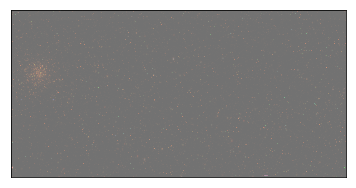

In [34]:
from scarlet.display import AsinhMapping

stretch = 0.2
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
img_rgb = scarlet.display.img_to_rgb(imageList)
plt.imshow(img_rgb,norm=LogNorm())
plt.yticks([])
plt.xticks([])
# Mark all of the sources from the detection cataog
# for k, src in enumerate(catalogueList[0]):
#     plt.text(src["x"], src["y"], str(k), color="red")



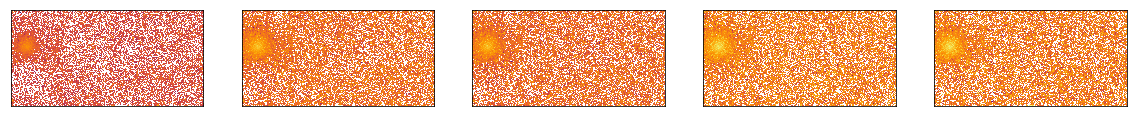

In [35]:
fig, ax = plt.subplots(1,5,figsize=(20,4))
for i,x in enumerate(imageList):
    ax[i].imshow(x,norm=LogNorm())
    ax[i].set_yticks([])
    ax[i].set_xticks([])

In [ ]:
blend = scarlet.Blend(sources, observation)
%time blend.fit(200)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend.loss), -blend.loss[-1]))
plt.plot(-np.array(blend.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')

In [25]:
model = blend.get_model()
model_ = observation.render(model)
residual = imageList-model_

# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model_, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual)

# Show the data, model, and residual



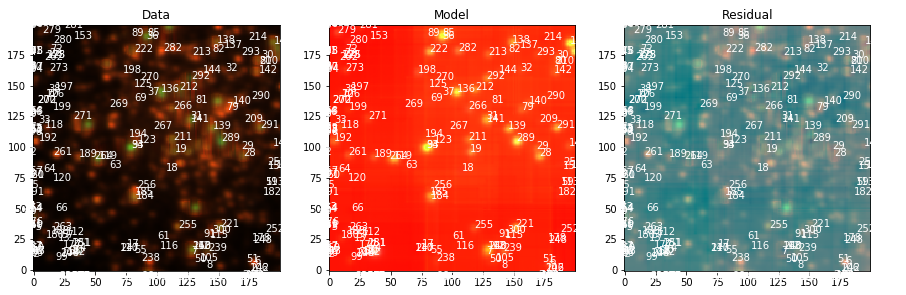

In [26]:
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")

for k,component in enumerate(blend):
    y,x = component.center
    ax[0].text(x, y, k, color="w")
    ax[1].text(x, y, k, color="w")
    ax[2].text(x, y, k, color="w")
#plt.show()

In [52]:
scarlet.display.show_sources(sources,
                             norm=norm,
                             observation=observation)#,
#                              show_rendered=True,
#                              show_observed=True)
#plt.show()


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

In [27]:
areas = [c._parameters[1]._data.shape[0] * c._parameters[1].shape[1] for c in blend.components]
plt.hist(areas)
plt.ylabel('Number of Sources')
plt.xlabel('Size')
plt.savefig('histogramOfSourcesPS.pdf',dpi=100)

IndexError: tuple index out of range

In [28]:
print ("----------------- {}".format(channels))
fluxes = []
for k, src in enumerate(sources):
    fluxes.append(scarlet.measure.flux(src).tolist())
    #print ("Source {}, Fluxes: {}".format(k, scarlet.measure.flux(src)))

----------------- ['u', 'g', 'r', 'i', 'z']


In [29]:
fluxesNoZero = [x for x in fluxes if 0.0 not in x]
print(len(fluxesNoZero))

301


In [30]:
def createMag(flux,zpMag):
    mag = (-2.5*np.log10(flux)) + zpMag
    return mag

In [36]:
Magnitudes = createMag(fluxesNoZero,29.41)

In [37]:
u = Magnitudes[:,0]

In [38]:
r = Magnitudes[:,2]
g = Magnitudes[:,1]

In [39]:
gMinusR = g-r

Text(0.5,0,'g - r')

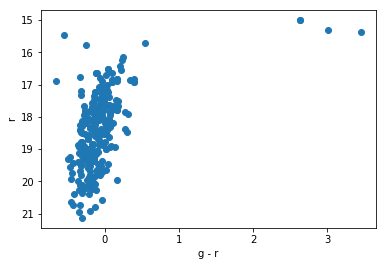

In [40]:
plt.plot(gMinusR,r,'o')
#plt.gca().invert_y_axis()
plt.gca().invert_yaxis()
plt.ylabel('r')
plt.xlabel('g - r')

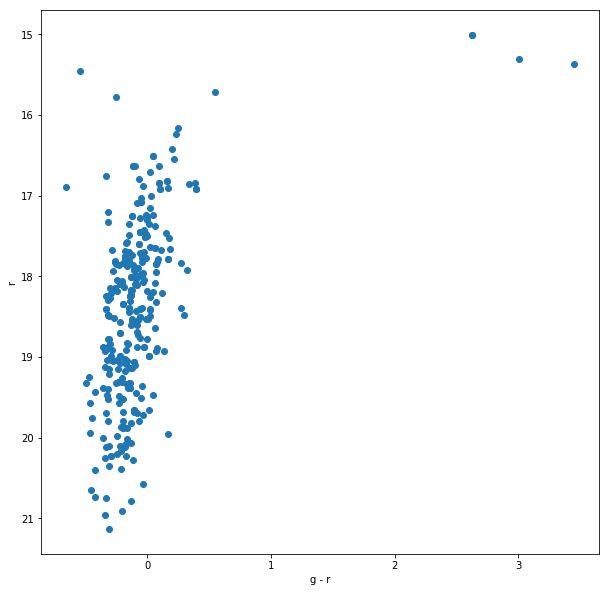

In [48]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(gMinusR,r,'o')
fig.gca().invert_yaxis()
ax.set_ylabel('r')
ax.set_xlabel('g - r')
fig.savefig('./CMDglob.pdf',dpi=100)